# Week 13
# Deep Learning for Regression

So far, we have seen how neural networks are used for classification tasks, such as image classification, text classification, text generation. Today we will apply neural network model to a regression task.

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0


## Load Auto MPG Dataset

This dataset is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/auto+mpg)

**Attribute Information**:

1. mpg: continuous
2. cylinders: multi-valued discrete
3. displacement: continuous
4. horsepower: continuous
5. weight: continuous
6. acceleration: continuous
7. model year: multi-valued discrete
8. origin: multi-valued discrete
9. car name: string (unique for each instance)

The goal of this project is to train a model that predicts "MPG" using other features.

In [10]:
# Load the dataset
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(url, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


## Data Preprocessing
- Check for missing values
- Handle categorical features
- Split into training and test set

In [11]:
# Are there any missing values?
# If so, how should we handle them?
dataset.isnull().sum()


MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

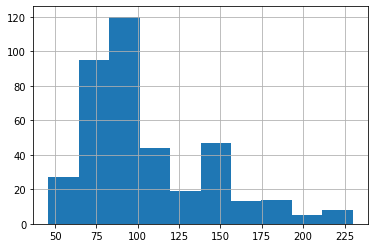

In [14]:
# Consider using mean or median to fill the missing values
dataset['Horsepower'].hist()
# Median is a better choice since the data is skewed
median = dataset['Horsepower'].median()
dataset['Horsepower'] = dataset['Horsepower'].fillna(median)

In [15]:
dataset.isnull().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [16]:
# The "Origin" column is really categorical, not numeric. 
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,USA
1,15.0,8,350.0,165.0,3693.0,11.5,70,USA
2,18.0,8,318.0,150.0,3436.0,11.0,70,USA
3,16.0,8,304.0,150.0,3433.0,12.0,70,USA
4,17.0,8,302.0,140.0,3449.0,10.5,70,USA


In [17]:
# Convert "Origin" to a one-hot vector:
# "USA" --> (0, 0, 1)
# "Europe" --> (0, 1, 0)
# "Japan" --> (1, 0, 0)
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1


In [18]:
# Split the data into training set (80%) and test set (20%)
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(dataset, test_size=0.20)
print(df_train.shape, df_test.shape)

(318, 10) (80, 10)


## Inspect the Data
- Inspect the distribution of each individual feature:
    - descriptive statistics
    - histogram
- Inspect the relationship between features:
    - correlation coefficients
    - scatter plots

In [19]:
# Compute descriptive statistices: min, max, mean, median, standard deviation
df_train.describe()


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
count,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000,318.000000
mean,23.713522,5.405660,191.419811,103.952830,2942.484277,15.503459,75.993711,0.172956,0.201258,0.625786
std,7.882959,1.711595,105.506458,38.470493,843.792654,2.726668,3.776061,0.378805,0.401572,0.484682
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,0.000000,0.000000,0.000000
25%,17.500000,4.000000,101.750000,75.000000,2220.750000,13.725000,73.000000,0.000000,0.000000,0.000000
50%,23.100000,4.000000,140.000000,93.500000,2730.000000,15.500000,76.000000,0.000000,0.000000,1.000000
75%,29.975000,8.000000,262.000000,123.750000,3571.250000,17.075000,79.000000,0.000000,0.000000,1.000000
max,46.600000,8.000000,455.000000,225.000000,4997.000000,23.700000,82.000000,1.000000,1.000000,1.000000


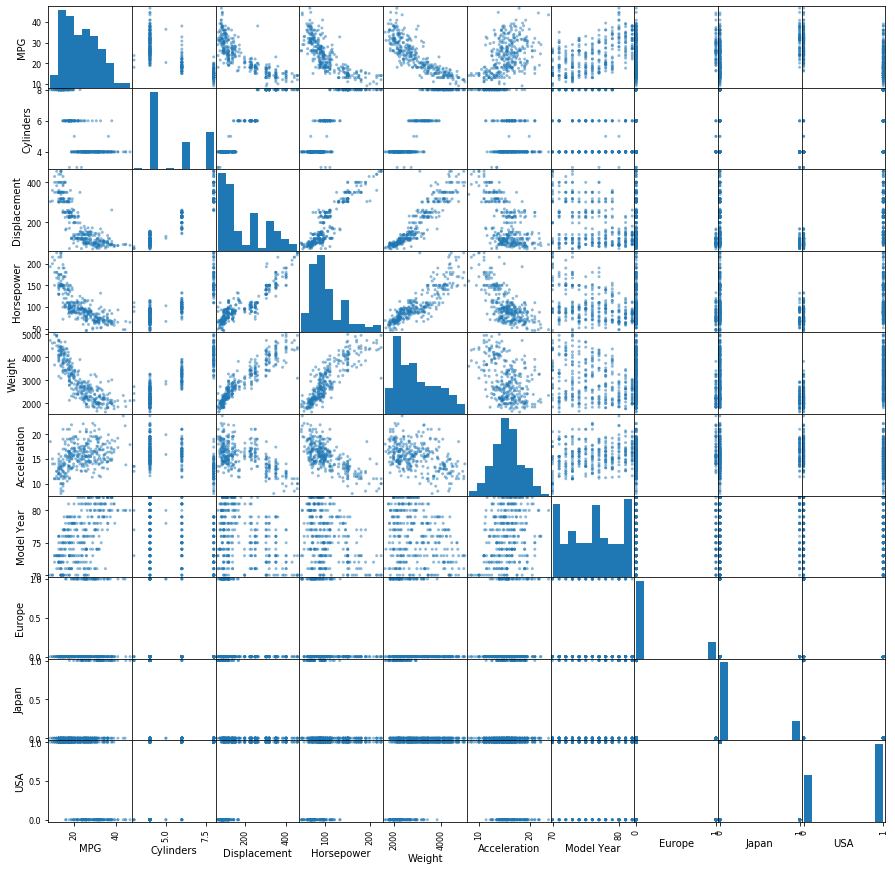

In [22]:
# Plot histogram and pairwise scatter plots for numerical variables
pd.plotting.scatter_matrix(df_train, figsize=(15, 15))
plt.show()


In [ ]:
# Calculate the correlation coefficient between MPG and every other feature



## Build the Model
- Transform data into proper format
- Normalize data
- Build neural network
- Specify loss function and training method

In [24]:
# Separate the "MPG" feature from the rest.
df_train_labels = df_train['MPG']
# df_train_data = df_train.loc[:, ['Cylinders', 'Displacement',...]]
df_train_data = df_train.iloc[:, 1:]
df_train_data.head()

df_test_labels = df_test['MPG']
df_test_data = df_test.iloc[:, 1:]
df_test_data.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
91,8,400.0,150.0,4464.0,12.0,73,0,0,1
299,4,141.0,71.0,3190.0,24.8,79,1,0,0
193,6,200.0,81.0,3012.0,17.6,76,0,0,1
92,8,351.0,158.0,4363.0,13.0,73,0,0,1
347,4,85.0,65.0,1975.0,19.4,81,0,1,0


In [ ]:
# Normalize the data by applying the following tranformation:
# x <-- (x - mean) / std



In [ ]:
# Build a 3-layer neural network:
# 1. input layer (what is the input shape?)
# 2. hidden layer with 64 nodes and ReLU activation
# 3. output layer (what is the output shape?)



In [ ]:
# Use model.compile() to specify:
# 1. loss = 'mse'
# 2. optimizer = tf.keras.optimizers.RMSprop(0.001)
# 3. metrics = ['mae', 'mse']



In [ ]:
# Display a summary of the model



## Train the Model
- Train the model
- Analyze the loss curve
- Improve the model

In [ ]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
)

In [ ]:
# Visualize the model's training progress using the statistics stored in
# the "history" object
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head()

In [ ]:
# Plot training MAE and validation MAE against epochs



In [ ]:
# Plot training MSE and validation MSE against epochs



In [ ]:
# Re-train the model with 100 epochs



## Evaluate the Model
- Evaluate the model on the test set
- Visualize the predictions

In [7]:
# Evalute the performance on the test set



In [8]:
# Visualize model predictions against true values



In [ ]:
# Plot the histogram of prediction errors

